In [1]:
!pip3 install git+https://github.com/Centre-automatique-et-systemes/lena.git gwpy &> /dev/null
!pip3 install git+https://github.com/aliutkus/torchinterp1d.git gwpy &> /dev/null

La syntaxe de la commande n'est pas correcte.
La syntaxe de la commande n'est pas correcte.


In [1]:
import sys ; sys.path.append('../')
import torch.optim as optim
import torch
import seaborn as sb
import pytorch_lightning as pl
import numpy as np
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import time

from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from learn_KKL.luenberger_observerV2 import LuenbergerObserver
from learn_KKL.system import RevDuffing
from learn_KKL.learner import Learner
from learn_KKL.raffinementV3 import *
#sb.set_style('whitegrid')

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Set up the system
system = RevDuffing()

In [4]:
# Instantiate the observer
start = time.time()
observer = LuenbergerObserver(dim_x=2, dim_y=1, method='Supervised', recon_lambda=0.8, wc=0.03,
                              activation=torch.nn.SiLU())
observer.set_dynamics(system)
# Generate (x_i, z_i) data by running system backward, then system + observer
# forward in time
data,grid = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), [47,47],
                                  method='adaptative')
end = time.time()
print("temps de génération des données : ",int((end - start) / 60), "min et", end - start - 60 * int((end - start) / 60), "s")

temps de génération des données :  4 min et 14.524669408798218 s


In [138]:
data_x1 = data[:,[0,2,3,4]]
data_x2 = data[:,[1,2,3,4]]

torch.Size([2209, 5])


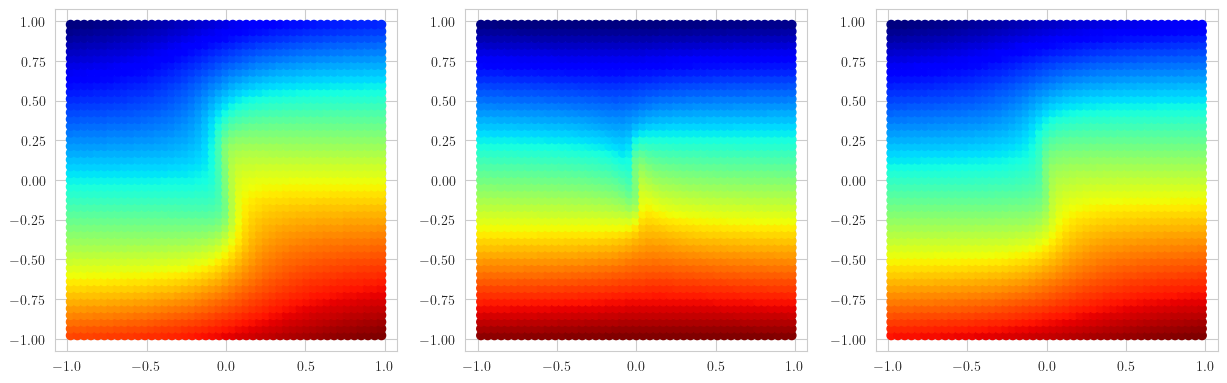

In [5]:
print(data.shape)
im,ax = plt.subplots(1,3,figsize=(15,15))
for i in range(3):
    ax[i].scatter(data[:,0],data[:,1],c = data[:,2+i],cmap='jet')
    ax[i].axis('square')
plt.show()

tensor(0.1759) tensor(0.0003)


C:\Users\pchauris\AppData\Local\Temp\ipykernel_2692\2627124297.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[i],shrink=0.3)


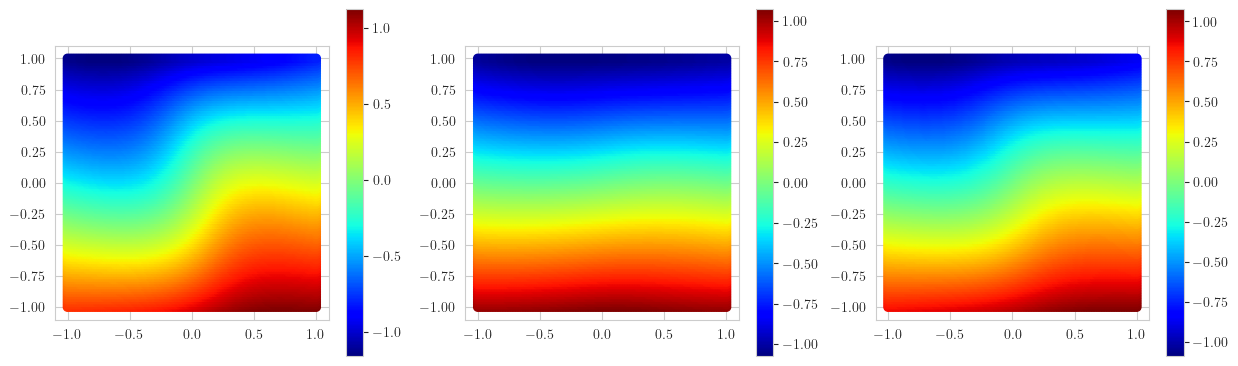

C:\Users\pchauris\AppData\Local\Temp\ipykernel_2692\2627124297.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[i],shrink=0.3)


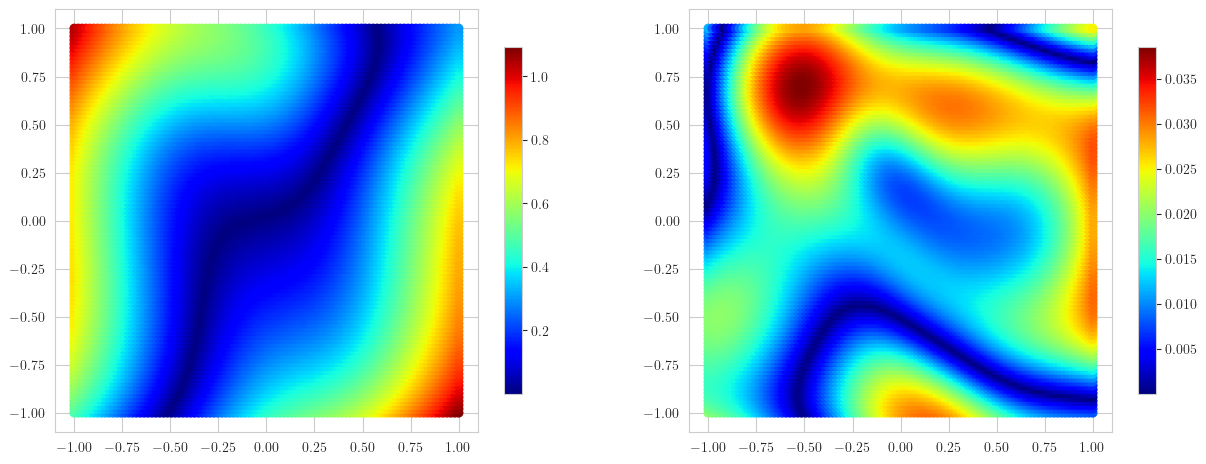

In [83]:
x = np.linspace(-1,1,100)
X,Y = np.meshgrid(x,x)
X,Y = X.flatten(),Y.flatten()
mesh = np.stack((X,Y),-1)
mesh = torch.as_tensor(mesh)
z_hat = observer.encoder(mesh).detach()
x_hat = observer.decoder(z_hat).detach()
print(observer.loss("T_star",mesh,x_hat,0),observer.loss("T_star",mesh,x_hat,1))
error = torch.abs(mesh-x_hat)

im,ax = plt.subplots(1,3,figsize=(15,15))
for i in range(3):
    pc=ax[i].scatter(mesh[:,0],mesh[:,1],c = z_hat[:,i],cmap='jet')
    ax[i].axis('square')
    im.colorbar(pc,ax=ax[i],shrink=0.3)
plt.show()

im,ax = plt.subplots(1,2,figsize=(15,15))
for i in range(2):
    pc=ax[i].scatter(mesh[:,0],mesh[:,1],c = error[:,i],cmap='jet')
    ax[i].axis('square')
    im.colorbar(pc,ax=ax[i],shrink=0.3)
plt.show()

In [8]:
# raffinement sur un critere
start = time.time()
data1, grid1, data2, grid2 = observer.iterate2(data,grid,data,grid)
end = time.time()
print("temps d'une iteration de raffinement :",int((end-start)/60),"min et",end-start-60*int((end-start)/60),"s")

[860 880 874 780 525   6 685 195 651 363  17 223 835 748 600 855 858 736
 448 867]
[860 880 874 780 525   6 685 195 651 363  17 223 835 748 600 855 858 736
 448 867]
[860 880 874 780 525   6 685 195 651 363  17 223 835 748 600 855 858 736
 448 867]
[860 880 874 780 525   6 685 195 651 363  17 223 835 748 600 855 858 736
 448 867]
[860 880 874 780 525   6 685 195 651 363  17 223 835 748 600 855 858 736
 448 867]
[860 880 874 780 525   6 685 195 651 363  17 223 835 748 600 855 858 736
 448 867]
[860 880 874 780 525   6 685 195 651 363  17 223 835 748 600 855 858 736
 448 867]
[860 880 874 780 525   6 685 195 651 363  17 223 835 748 600 855 858 736
 448 867]
temps d'une iteration de raffinement : 8 min et 14.321293354034424 s


[2141  306  955 1387  439  576 1482  984 1494 1782 1949  921 1249 1238
  406  854  241  120  169 2015]
[1643 1592 1032  415  201  194 1266  549  126  363  778 2105  702 1359
 1859 1595  258  851  341  368]


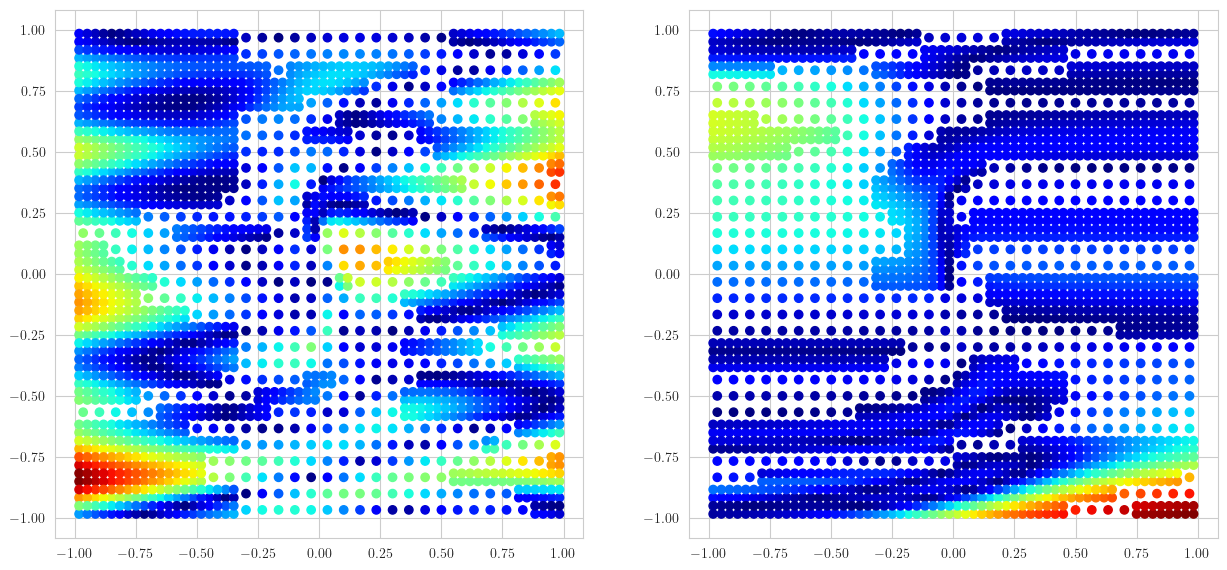

In [13]:
# les 2 grilles raffinées sur les criteres
crit1 = erreur_gp(data1[:,0].numpy(),data1[:,2:5].numpy())
crit2 = erreur_gp(data2[:,2].numpy(),data2[:,2:5].numpy())

_,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.scatter(data1[:,0],data1[:,1],c=crit1,cmap='jet')
ax1.axis('square')
ax2.scatter(data2[:,0],data2[:,1],c=crit2,cmap='jet')
ax2.axis('square')
plt.show()

In [55]:
data_uni, val_data_uni = train_test_split(data, test_size=0.3, shuffle=True)
datax1, val_data1 = train_test_split(data1, test_size=0.3, shuffle=True)
datax2, val_data2 = train_test_split(data2, test_size=0.3, shuffle=True)
print(data1.shape,data2.shape)

torch.Size([2193, 5]) torch.Size([2211, 5])


In [61]:
# Train the forward transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-6}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T = Learner(observer=observer, system=system, training_data=data_uni,
                    validation_data=val_data_uni, axe=None, method='T', batch_size=10,
                    lr=1e-3, optimizer=optim.Adam,
                    optimizer_options=optimizer_options,
                    scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                    scheduler_options=scheduler_options)
# Define logger and checkpointing
logger = TensorBoardLogger(save_dir=learner_T.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\runs\Reversed_Duffing_Oscillator\Supervised/T\exp_37


In [62]:
# To see logger in tensorboard, copy the following output name_of_folder
print(f'Logs stored in {learner_T.results_folder}/tb_logs')
# which should be similar to jupyter_notebooks/runs/method/exp_0/tb_logs/
# Then type this in terminal:
# tensorboard --logdir=name_of_folder --port=8080

# Train and save results
trainer.fit(learner_T)
# learner_T.save_results(limits=np.array([[-1, 1.], [-1., 1.], [-1., 1.]]),
#                        nb_trajs=2, tsim=(0, 60), dt=1e-2,
#                        checkpoint_path=checkpoint_callback.best_model_path)

Missing logger folder: C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\runs\Reversed_Duffing_Oscillator\Supervised/T\exp_37/tb_logs\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.1 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Logs stored in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\runs\Reversed_Duffing_Oscillator\Supervised/T\exp_37/tb_logs


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\pchauris\stage\dir2\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the nu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [86]:
# Train the inverse transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T_star = Learner(observer=observer, system=system, training_data=data_uni,
                         validation_data=val_data_uni, axe=0, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)

# Define logger and checkpointing
logger1 = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Results saved in in C:\Users\pchauris\stage\dir2\repo\learn_observe_KKL\jupyter_notebooks\runs\Reversed_Duffing_Oscillator\Supervised/T_star\exp_26


In [87]:
# Train and save results
trainer.fit(learner_T_star)
# learner_T_star.save_results(limits=np.array([[-1, 1.], [-1., 1.]]),
#                             nb_trajs=2, tsim=(0, 60), dt=1e-2,
#                             checkpoint_path=checkpoint_callback.best_model_path)


  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
13.1 K    Trainable params
13.1 K    Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

ValueError: only one element tensors can be converted to Python scalars

torch.Size([900, 2])
tensor(0.0002)


C:\Users\pchauris\AppData\Local\Temp\ipykernel_8508\3305583801.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im.colorbar(pc,ax=ax[i],shrink=0.3)


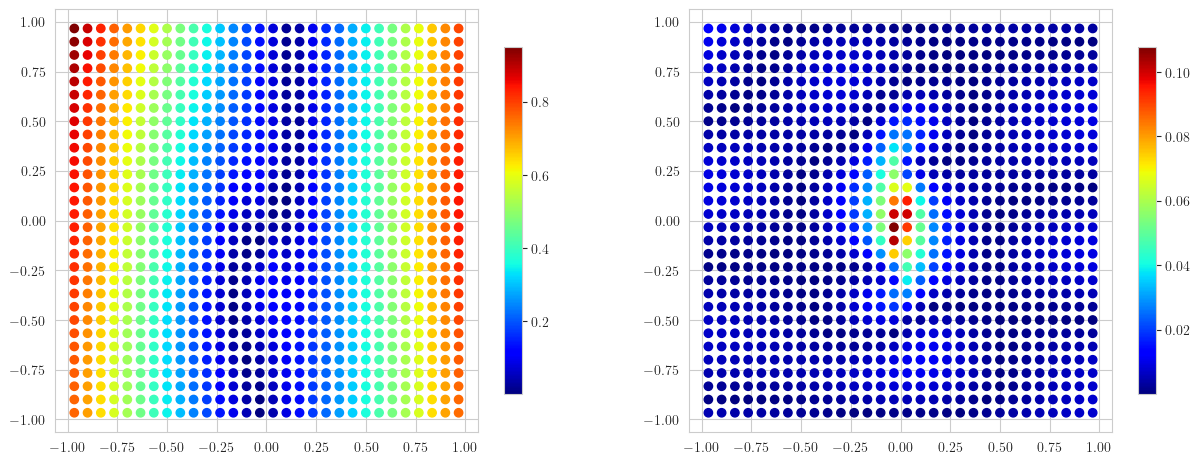

In [75]:
x_mesh = data[:, 0:2]
z_mesh = data[:, 2:5]
axe = 1
x_hat = learner_T_star.model("T_star",z_mesh).detach()
print(x_hat.shape)

erreur = torch.abs(x_hat - x_mesh).detach()
rmse = observer.loss("T_star",x_mesh,x_hat,axe)
print(rmse)
im,ax = plt.subplots(1,2,figsize=(15,15))
for i in range(2):
    pc=ax[i].scatter(x_mesh[:,0],x_mesh[:,1],c = erreur[:,i],cmap='jet')
    ax[i].axis('square')
    im.colorbar(pc,ax=ax[i],shrink=0.3)
plt.show()